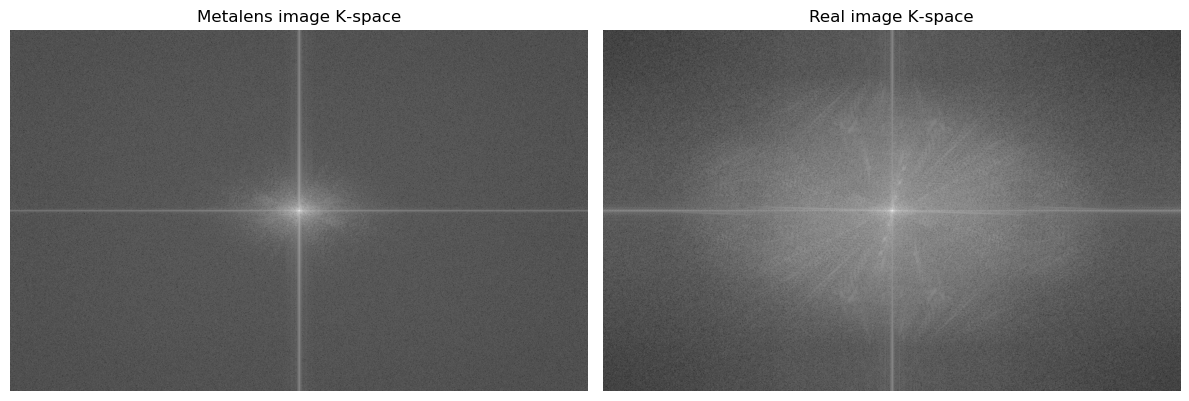

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ——————————————
# 사용자 설정: 이미지 파일 경로
metalens_path = 'metalens_image.png'   # 메타렌즈로 촬영한 이미지 파일
real_path     = 'real_image.png'       # 실제 기준 이미지 파일
# ——————————————

# 이미지 로드 및 그레이스케일 변환
metalens_img = Image.open(metalens_path).convert('L')
real_img     = Image.open(real_path).convert('L')

metalens_arr = np.array(metalens_img)
real_arr     = np.array(real_img)

# k‑space(주파수 영역) 스펙트럼 계산 함수
def compute_kspace_spectrum(img_arr):
    # 2D FFT
    k        = np.fft.fft2(img_arr)
    # DC 성분을 중앙으로 이동
    k_shift  = np.fft.fftshift(k)
    # 로그 스케일로 대비 향상
    spectrum = np.log(np.abs(k_shift) + 1)
    return spectrum

# 각 이미지의 k‑space 스펙트럼 계산
metalens_spec = compute_kspace_spectrum(metalens_arr)
real_spec     = compute_kspace_spectrum(real_arr)

# ———— 플롯 그리기 ————
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Metalens image K‑space')
plt.imshow(metalens_spec, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Real image K‑space')
plt.imshow(real_spec, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 47116 (\N{HANGUL SYLLABLE REN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_25837/1182680223.py:40

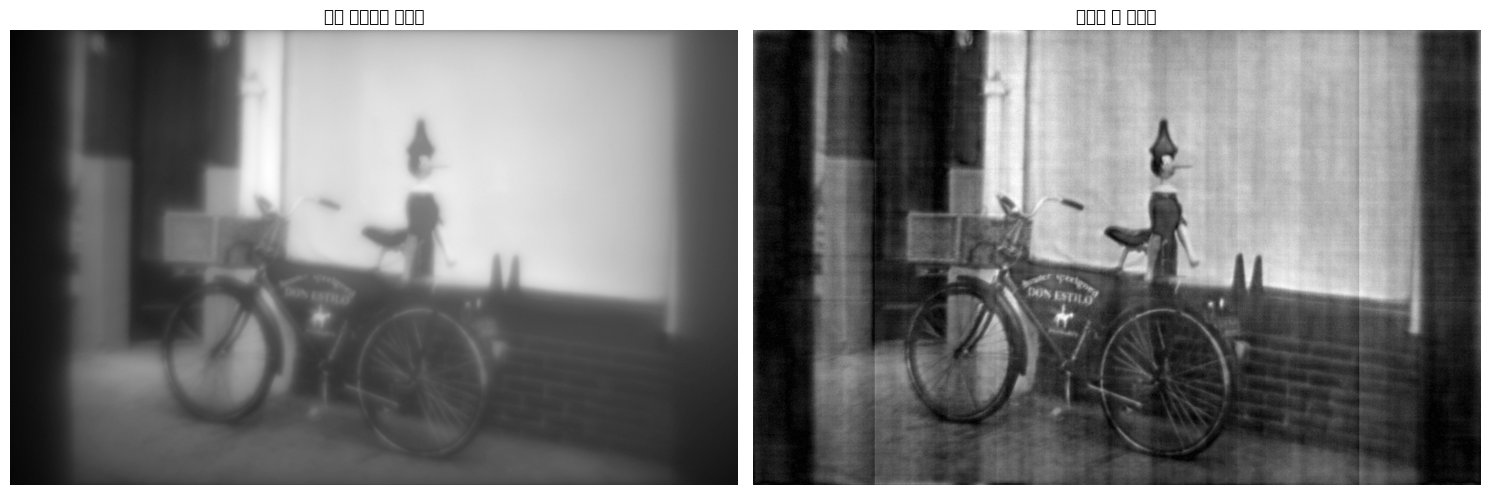

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 사용자 설정
metalens_path = 'metalens_image.png'
real_path     = 'real_image.png'

# 1) 이미지 로드 → gray
meta = np.array(Image.open(metalens_path).convert('L'))
real = np.array(Image.open(real_path).convert('L'))

# 2) FFT → shift
K_meta = np.fft.fftshift(np.fft.fft2(meta))
K_real = np.fft.fftshift(np.fft.fft2(real))

# 3) 필터 생성 (ratio filter)
eps    = 1e-3
H      = np.abs(K_real) / (np.abs(K_meta) + eps)
# 너무 큰 게인 방지
H_clipped = np.clip(H, 1.0, 10.0)  

# 4) 메타렌즈 k-space에 필터 곱하기
K_meta_sharp = K_meta * H_clipped

# 5) 역 shift → IFFT → 절댓값
img_sharp = np.abs(np.fft.ifft2(np.fft.ifftshift(K_meta_sharp)))

# 6) 시각화
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('원본 메타렌즈 이미지')
plt.imshow(meta, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2)
plt.title('샤프닝 후 이미지')
plt.imshow(img_sharp, cmap='gray'); plt.axis('off')
# plt.subplot(1,3,3)
# plt.title('차이 (샤프닝–원본)')
# plt.imshow(img_sharp - meta, cmap='bwr'); plt.axis('off')
plt.tight_layout()
plt.show()


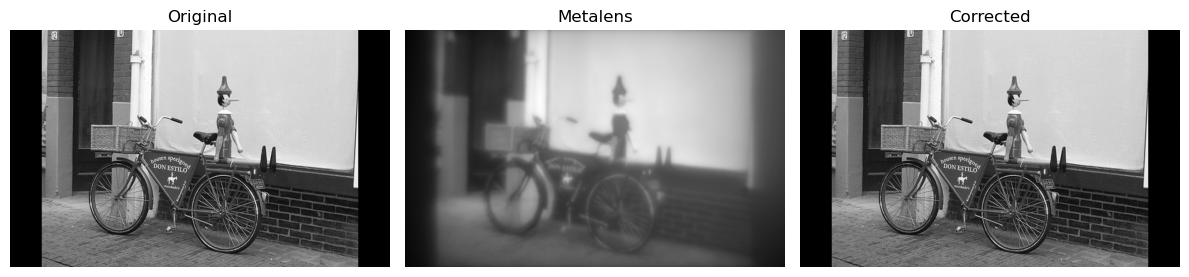

True

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_fft(img):
    """이미지의 2D FFT와 중앙 정렬된 스펙트럼 반환"""
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return fshift

def compute_ifft(fshift):
    """중앙 정렬된 스펙트럼을 공간 영역 이미지로 역변환"""
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

# 1. 이미지 읽기 (그레이스케일)
orig = cv2.imread('real_image.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
metalens = cv2.imread('metalens_image.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)

# 2. k-space 계산
F_orig = compute_fft(orig)
F_metal = compute_fft(metalens)

# 3. 필터 설계: H = F_orig / (F_metal + eps)
eps = 1e-6  # 분모 안정화를 위한 작은 값
H = F_orig / (F_metal + eps)

# (선택) 필터의 극단치 제거(클리핑) 또는 스무딩
H_mag = np.abs(H)
H_phase = np.angle(H)
H_mag_clipped = np.clip(H_mag, 0, np.percentile(H_mag, 99))
H = H_mag_clipped * np.exp(1j * H_phase)

# 4. 메타렌즈 k-space에 필터 적용
F_corrected = F_metal * H

# 5. 역변환하여 보정된 이미지 얻기
corrected = compute_ifft(F_corrected)

# 6. 결과 정규화 및 uint8 변환
def normalize_uint8(img):
    img_clipped = np.clip(img, 0, None)
    img_norm = (img_clipped - img_clipped.min()) / (img_clipped.ptp() + 1e-9)
    return (img_norm * 255).astype(np.uint8)

orig_u8      = normalize_uint8(orig)
metalens_u8  = normalize_uint8(metalens)
corrected_u8 = normalize_uint8(corrected)

# 7. 결과 시각화
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original');     plt.imshow(orig_u8,      cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Metalens');     plt.imshow(metalens_u8,  cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Corrected');    plt.imshow(corrected_u8, cmap='gray'); plt.axis('off')
plt.tight_layout()
plt.show()

# 8. 보정 이미지 저장
cv2.imwrite('metalens_corrected.png', corrected_u8)


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_fft(img):
    f = np.fft.fft2(img)
    return np.fft.fftshift(f)

def compute_ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    return np.real(np.fft.ifft2(f_ishift))

def normalize_uint8(img):
    img = np.clip(img, 0, None)
    img = (img - img.min()) / (img.ptp() + 1e-9)
    return (img * 255).astype(np.uint8)

def create_and_save_filter(orig_path, metalens_path, filter_path="filter.npy", eps=1e-6):
    # 1) 원본·메타렌즈 이미지 읽기
    orig     = cv2.imread(orig_path,     cv2.IMREAD_GRAYSCALE).astype(np.float32)
    metalens = cv2.imread(metalens_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    # 2) 크기 맞추기 (원본 크기에 맞춤)
    if orig.shape != metalens.shape:
        metalens = cv2.resize(metalens, (orig.shape[1], orig.shape[0]), interpolation=cv2.INTER_LINEAR)

    # 3) k‑space 계산
    F_orig  = compute_fft(orig)
    F_metal = compute_fft(metalens)

    # —— 여기가 필터 생성 부분! —— 
    H = F_orig / (F_metal + eps)   # H: 보정 필터 (원본 스펙트럼 ÷ 메타렌즈 스펙트럼)

    # 4) 필터 저장
    np.save(filter_path, H)
    print(f"필터를 '{filter_path}'에 저장했습니다. 크기: {H.shape}")

def apply_filter_to_image(metalens_path, filter_path="filter.npy", output_path="corrected.png"):
    # 1) 저장된 필터 로드
    H = np.load(filter_path)
    h, w = H.shape

    # 2) 새로운 메타렌즈 이미지 읽기
    metalens = cv2.imread(metalens_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    # 3) 크기 맞추기 (필터 크기에 맞춤)
    if metalens.shape != (h, w):
        metalens = cv2.resize(metalens, (w, h), interpolation=cv2.INTER_LINEAR)

    # 4) k‑space -> 필터 적용 -> 역변환
    F_metal   = compute_fft(metalens)
    F_correct = F_metal * H
    corrected = compute_ifft(F_correct)

    # 5) 정규화 및 저장
    corrected_u8 = normalize_uint8(corrected)
    cv2.imwrite(output_path, corrected_u8)
    print(f"보정된 이미지를 '{output_path}'에 저장했습니다.")


# 1) 한 번만 필터 생성
create_and_save_filter("real_image.png", "metalens_image.png", filter_path="filter.npy")

# 2) 다른 메타렌즈 이미지에 동일 필터 적용
apply_filter_to_image("meta_image.png", filter_path="filter.npy", output_path="metalens_new_corrected.png")


필터를 'filter.npy'에 저장했습니다. 크기: (800, 1280)
보정된 이미지를 'metalens_new_corrected.png'에 저장했습니다.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_fft(img):
    f = np.fft.fft2(img)
    return np.fft.fftshift(f)

def compute_ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    return np.real(np.fft.ifft2(f_ishift))

def normalize_uint8(img):
    img = np.clip(img, 0, None)
    img = (img - img.min()) / (img.ptp() + 1e-9)
    return (img * 255).astype(np.uint8)

def create_and_save_filter_color(orig_path, metalens_path,
                                 filter_path="filter_color.npy",
                                 eps=1e-6):
    # 1) 컬러 이미지 읽기 (BGR, float32)
    orig     = cv2.imread(orig_path,     cv2.IMREAD_COLOR).astype(np.float32)
    metalens = cv2.imread(metalens_path, cv2.IMREAD_COLOR).astype(np.float32)

    # 2) 크기 맞추기
    if orig.shape[:2] != metalens.shape[:2]:
        metalens = cv2.resize(
            metalens,
            (orig.shape[1], orig.shape[0]),
            interpolation=cv2.INTER_LINEAR
        )

    # 3) 채널별 k‑space 계산 및 필터 생성
    H = np.zeros(orig.shape, dtype=np.complex64)  # (H, W, 3)
    for c in range(3):
        F_orig_c  = compute_fft(orig[:,:,c])
        F_metal_c = compute_fft(metalens[:,:,c])
        # —— 여기가 채널별 필터 생성 부분! —— 
        H[:,:,c] = F_orig_c / (F_metal_c + eps)

    # 4) 필터 저장
    np.save(filter_path, H)
    print(f"컬러 필터를 '{filter_path}'에 저장했습니다. shape = {H.shape}")

def apply_filter_to_image_color(metalens_path,
                                filter_path="filter_color.npy",
                                output_path="corrected_color.png"):
    # 1) 저장된 컬러 필터 로드
    H = np.load(filter_path)                   # shape = (h, w, 3)
    h, w, _ = H.shape

    # 2) 새로운 메타렌즈 컬러 이미지 읽기
    metalens = cv2.imread(metalens_path, cv2.IMREAD_COLOR).astype(np.float32)
    if metalens.shape[:2] != (h, w):
        metalens = cv2.resize(
            metalens,
            (w, h),
            interpolation=cv2.INTER_LINEAR
        )

    # 3) 채널별 k‑space 보정
    corrected = np.zeros_like(metalens, dtype=np.float32)
    for c in range(3):
        F_metal_c = compute_fft(metalens[:,:,c])
        F_corr_c  = F_metal_c * H[:,:,c]
        corrected[:,:,c] = compute_ifft(F_corr_c)

    # 4) 채널별 정규화 및 uint8 변환
    corrected_u8 = np.zeros_like(metalens, dtype=np.uint8)
    for c in range(3):
        corrected_u8[:,:,c] = normalize_uint8(corrected[:,:,c])

    # 5) 결과 저장
    cv2.imwrite(output_path, corrected_u8)
    print(f"보정된 컬러 이미지를 '{output_path}'에 저장했습니다.")

# 1) 컬러 필터 생성 (한 번만 실행)
create_and_save_filter_color("000057_real.png",
                                "000057_meta.png",
                                filter_path="filter_color.npy")

# 2) 다른 메타렌즈 컬러 이미지 보정
apply_filter_to_image_color("000057_meta.png",
                            filter_path="filter_color.npy",
                            output_path="metalens_new_corrected.png")

# # --- 이미 생성된 컬러 필터 로드 ---
# H = np.load("filter_color.npy")   # shape = (h, w, 3)
# h, w, _ = H.shape

# # --- 원본·메타렌즈(보정 대상) 컬러 이미지 읽기 ---
# orig = cv2.imread("real_image.png", cv2.IMREAD_COLOR).astype(np.float32)
# metalens = cv2.imread("metalens_image.png", cv2.IMREAD_COLOR).astype(np.float32)

# # --- 크기 맞추기 (필터 크기에) ---
# if orig.shape[:2] != (h, w):
#     orig = cv2.resize(orig, (w, h), interpolation=cv2.INTER_LINEAR)
# if metalens.shape[:2] != (h, w):
#     metalens = cv2.resize(metalens, (w, h), interpolation=cv2.INTER_LINEAR)

# # --- k‑space 보정 적용 ---
# def fft2c(x):    return np.fft.fftshift(np.fft.fft2(x))
# def ifft2c(X):   return np.real(np.fft.ifft2(np.fft.ifftshift(X)))

# restored = np.zeros_like(metalens, dtype=np.float32)
# for c in range(3):
#     Fm = fft2c(metalens[:,:,c])
#     Fc = Fm * H[:,:,c]
#     restored[:,:,c] = ifft2c(Fc)

# # --- 정규화 함수 ---
# def normalize_uint8(img):
#     img = np.clip(img, 0, None)
#     img = (img - img.min()) / (img.ptp() + 1e-9)
#     return (img * 255).astype(np.uint8)

# orig_u8     = normalize_uint8(orig)
# metalens_u8 = normalize_uint8(metalens)
# restored_u8 = normalize_uint8(restored)

# # --- BGR→RGB 변환 (matplotlib 출력용) ---
# orig_rgb     = cv2.cvtColor(orig_u8,     cv2.COLOR_BGR2RGB)
# metalens_rgb = cv2.cvtColor(metalens_u8, cv2.COLOR_BGR2RGB)
# restored_rgb = cv2.cvtColor(restored_u8, cv2.COLOR_BGR2RGB)

# # --- 결과 플롯 ---
# plt.figure(figsize=(12,4))
# for i,(title, img) in enumerate([
#     ("Original",     orig_rgb),
#     ("Distorted",    metalens_rgb),
#     ("Corrected",    restored_rgb),
# ]):
#     plt.subplot(1,3,i+1)
#     plt.title(title)
#     plt.imshow(img)
#     plt.axis("off")
# plt.tight_layout()
# plt.show()


컬러 필터를 'filter_color.npy'에 저장했습니다. shape = (800, 1280, 3)
보정된 컬러 이미지를 'metalens_new_corrected.png'에 저장했습니다.


/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 47116 (\N{HANGUL SYLLABLE REN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:99: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_55482/3730291067.py:

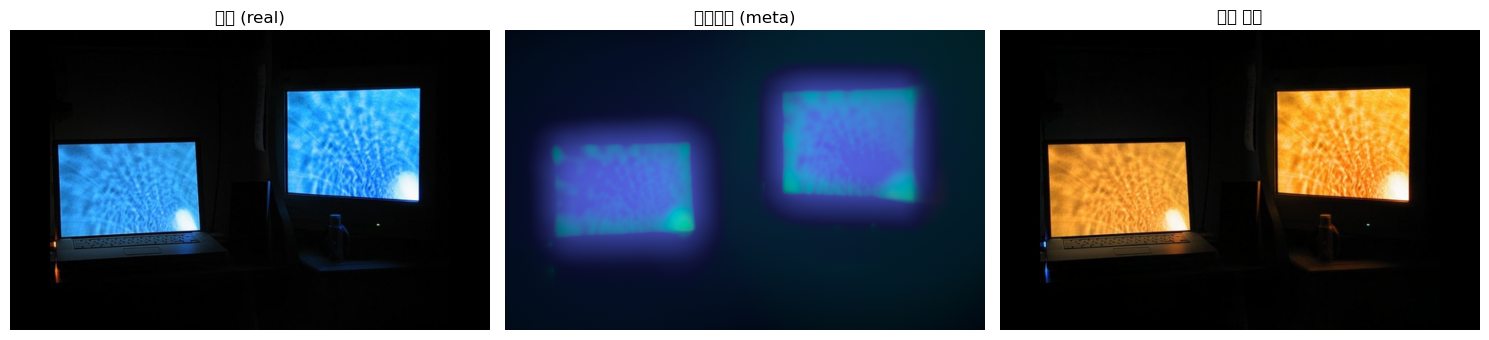

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ─── FFT / IFFT / 정규화 ────────────────────────────────────────────
def compute_fft(img: np.ndarray) -> np.ndarray:
    """2D FFT + shift (실수 2D 배열 → 복소 2D 배열)"""
    return np.fft.fftshift(np.fft.fft2(img))

def compute_ifft(fshift: np.ndarray) -> np.ndarray:
    """2D IFFT + unshift (복소 2D 배열 → 실수 2D 배열)"""
    return np.real(np.fft.ifft2(np.fft.ifftshift(fshift)))

def normalize_uint8(img: np.ndarray) -> np.ndarray:
    """실수 배열 [min..max] → uint8 [0..255]"""
    img = np.clip(img, 0, None)
    img = (img - img.min()) / (img.ptp() + 1e-9)
    return (img * 255).astype(np.uint8)

# ─── 1) 컬러 필터 생성 ────────────────────────────────────────────
def make_color_filter(orig_path: str,
                      meta_path: str,
                      eps: float = 1e-6) -> np.ndarray:
    """
    원본(real)과 메타렌즈(meta) 컬러 이미지의 k‑space 차이로
    3채널 복소 필터 H[...,c]를 계산해서 반환
    """
    # 이미지 읽기 (BGR→float32)
    orig  = cv2.imread(orig_path,  cv2.IMREAD_COLOR).astype(np.float32)
    meta  = cv2.imread(meta_path,  cv2.IMREAD_COLOR).astype(np.float32)
    if orig is None or meta is None:
        raise FileNotFoundError("경로를 확인하세요.")
    # 해상도 맞추기
    if orig.shape[:2] != meta.shape[:2]:
        meta = cv2.resize(meta, (orig.shape[1], orig.shape[0]),
                          interpolation=cv2.INTER_LINEAR)

    # 채널별 FFT, 필터 계산
    H = np.zeros(orig.shape, dtype=np.complex64)  # (H, W, 3)
    for c in range(3):
        Fo = compute_fft(orig[:,:,c])
        Fm = compute_fft(meta[:,:,c])
        H[:,:,c] = Fo / (Fm + eps)

    return H

# ─── 2) 컬러 필터 적용 ────────────────────────────────────────────
def apply_color_filter(meta_path: str,
                       H: np.ndarray) -> np.ndarray:
    """
    메타렌즈로 촬영한 컬러 이미지에 채널별 필터 H[...,c] 적용 후
    공간 영역으로 복원한 uint8 컬러 이미지를 반환
    """
    meta = cv2.imread(meta_path, cv2.IMREAD_COLOR).astype(np.float32)
    if meta is None:
        raise FileNotFoundError("경로를 확인하세요.")
    h, w, _ = H.shape
    # 해상도 맞추기
    if meta.shape[:2] != (h, w):
        meta = cv2.resize(meta, (w, h), interpolation=cv2.INTER_LINEAR)

    # 채널별 보정
    corrected = np.zeros_like(meta, dtype=np.float32)
    for c in range(3):
        Fm     = compute_fft(meta[:,:,c])
        Fcorr  = Fm * H[:,:,c]
        corrected[:,:,c] = compute_ifft(Fcorr)

    # uint8로 변환
    return normalize_uint8(corrected)

# ─── 3) 결과 플롯 ─────────────────────────────────────────────────
if __name__ == "__main__":
    # 예시 경로
    real_path   = "000045_real.png"
    meta_path   = "000045_meta.png"
    new_meta    = "000045_meta.png"

    # (1) 필터 생성
    H = make_color_filter(real_path, meta_path)

    # (2) 새로운 메타렌즈 이미지를 보정
    restored = apply_color_filter(new_meta, H)

    # (3) 원본·메타·보정 결과 읽어둔 뒤 BGR→RGB로 전환
    orig_bgr  = cv2.imread(real_path, cv2.IMREAD_COLOR)
    meta_bgr  = cv2.imread(new_meta,  cv2.IMREAD_COLOR)
    orig_rgb  = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    meta_rgb  = cv2.cvtColor(meta_bgr, cv2.COLOR_BGR2RGB)

    # (4) 플롯
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                              [orig_rgb, meta_rgb, restored],
                              ["원본 (real)", "메타렌즈 (meta)", "복원 결과"]):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


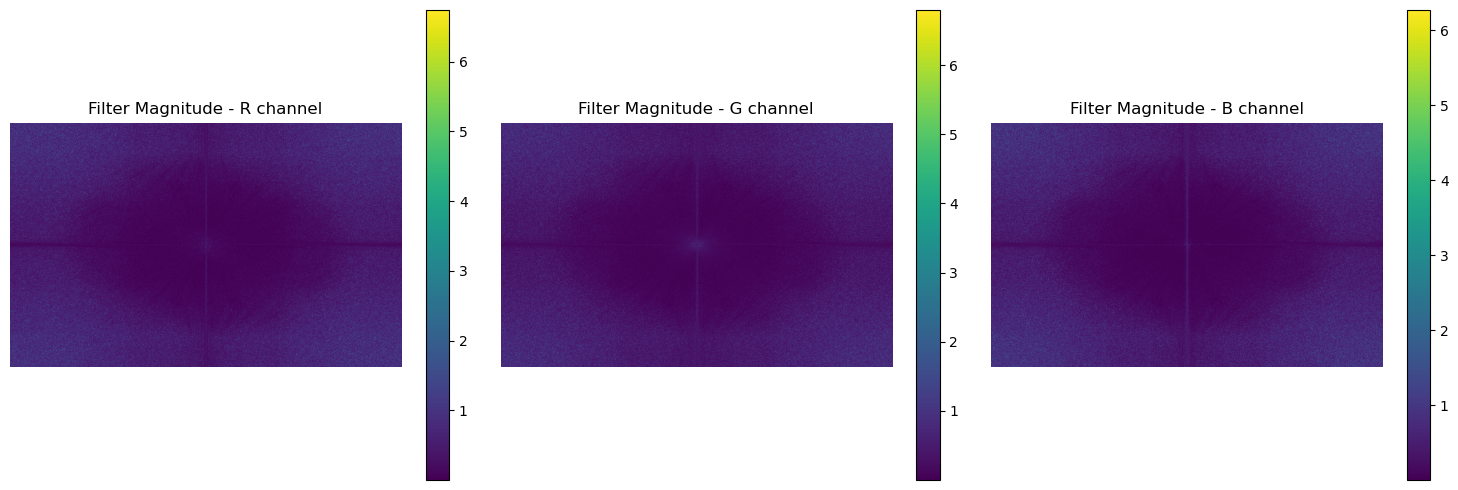

k-space 필터가 'kspace_filter.npy'로 저장되었습니다.


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def compute_kspace_filter(original_path, metalens_path, epsilon=1e-8):
    """
    원본 이미지와 메타렌즈 촬영 이미지를 각각 k-space로 변환한 뒤
    두 k-space의 비율로 필터를 계산합니다.

    Args:
        original_path (str): 원본 이미지 파일 경로
        metalens_path (str): 메타렌즈 촬영 이미지 파일 경로
        epsilon (float): 분모가 0이 되는 것을 방지하기 위한 작은 값

    Returns:
        kspace_orig (np.ndarray): 원본 이미지의 k-space (H, W, 3)
        kspace_metalens (np.ndarray): 메타렌즈 이미지의 k-space (H, W, 3)
        H_filter (np.ndarray): 채널별 k-space 필터 (H, W, 3)
    """
    # 이미지 읽기 및 float32 변환
    orig = cv2.imread(original_path, cv2.IMREAD_COLOR).astype(np.float32)
    metalens = cv2.imread(metalens_path, cv2.IMREAD_COLOR).astype(np.float32)
    # BGR -> RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    metalens = cv2.cvtColor(metalens, cv2.COLOR_BGR2RGB)
    
    # 채널별 k-space 및 필터 계산
    kspace_orig = []
    kspace_metalens = []
    filters = []
    for c in range(3):
        # 2D FFT + shift
        F_orig = np.fft.fftshift(np.fft.fft2(orig[:, :, c]))
        F_meta = np.fft.fftshift(np.fft.fft2(metalens[:, :, c]))
        # 필터: 메타렌즈 k-space / 원본 k-space
        H = F_meta / (F_orig + epsilon)
        kspace_orig.append(F_orig)
        kspace_metalens.append(F_meta)
        filters.append(H)
    
    # 배열 합치기 (H, W, 3)
    kspace_orig = np.stack(kspace_orig, axis=-1)
    kspace_metalens = np.stack(kspace_metalens, axis=-1)
    H_filter = np.stack(filters, axis=-1)
    return kspace_orig, kspace_metalens, H_filter


if __name__ == "__main__":
    # 경로 설정 (필요에 따라 수정)
    orig_path = "000015_real.png"
    metalens_path = "000015_meta.png"

    # k-space 및 필터 계산
    k_orig, k_meta, k_filter = compute_kspace_filter(orig_path, metalens_path)
    
    # 필터 크기(magnitude) 계산
    mag = np.abs(k_filter)
    
    # 채널별 필터 magnitude 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['R', 'G', 'B']
    for i, ax in enumerate(axes):
        im = ax.imshow(np.log1p(mag[:, :, i]), cmap='viridis')
        ax.set_title(f'Filter Magnitude - {channels[i]} channel')
        ax.axis('off')
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # 필터 저장
    np.save("kspace_filter.npy", k_filter)
    print("k-space 필터가 'kspace_filter.npy'로 저장되었습니다.")


보정된 이미지가 'metalens_corrected.jpg'에 저장되었습니다.


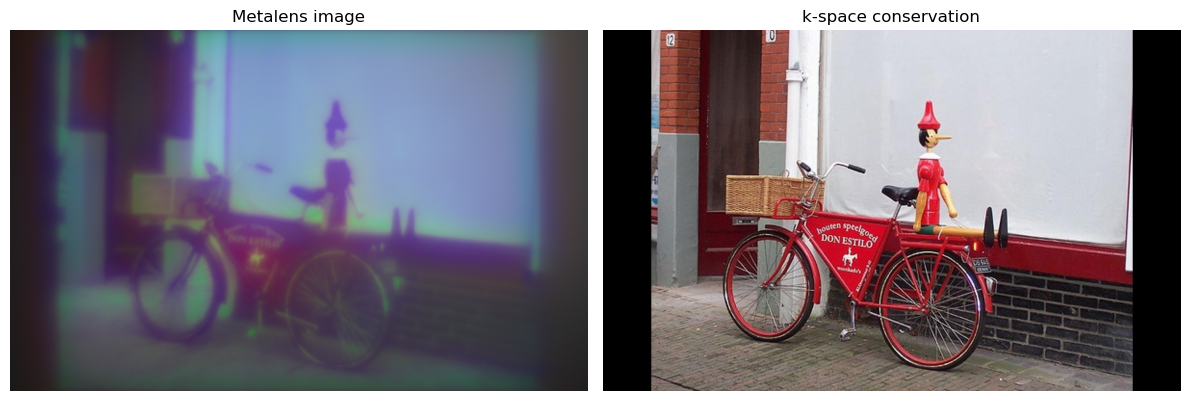

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def apply_kspace_filter(metalens_path, filter_path, output_path, epsilon=1e-8):
    """
    메타렌즈로 촬영한 이미지를 k-space 필터로 보정한 후
    공간 영역으로 재변환하여 저장합니다.

    Args:
        metalens_path (str): 원래 메타렌즈 이미지 파일 경로
        filter_path (str): numpy로 저장된 k-space 필터 파일 경로 (H_filter.npy)
        output_path (str): 보정된 이미지를 저장할 경로
        epsilon (float): 분모가 0이 되는 것을 방지하기 위한 작은 값
    """
    # 이미지 읽기 및 RGB 변환
    img = cv2.imread(metalens_path, cv2.IMREAD_COLOR).astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 필터 로드 (H_filter: H, W, 3)
    H_filter = np.load(filter_path)

    # 각 채널별 k-space 적용 및 역변환
    corrected_channels = []
    for c in range(3):
        # metalens k-space
        F_meta = np.fft.fftshift(np.fft.fft2(img[:, :, c]))
        # 보정된 k-space: F_meta / H_filter
        F_corr = F_meta / (H_filter[:, :, c] + epsilon)
        # inverse FFT
        f_ishift = np.fft.ifftshift(F_corr)
        img_corr = np.real(np.fft.ifft2(f_ishift))

        corrected_channels.append(img_corr)

    # 채널 합치기 및 uint8 변환
    img_corr_rgb = np.stack(corrected_channels, axis=-1)
    img_corr_rgb = np.clip(img_corr_rgb, 0, 255).astype(np.uint8)

    # RGB -> BGR로 변환 후 저장
    img_bgr = cv2.cvtColor(img_corr_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, img_bgr)
    print(f"보정된 이미지가 '{output_path}'에 저장되었습니다.")

    # 결과 시각화 (원본 vs 보정)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # 원본 메타렌즈 이미지 표시
    axes[0].imshow(cv2.cvtColor(cv2.imread(metalens_path), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Metalens image')
    axes[0].axis('off')
    # 보정된 이미지 표시
    axes[1].imshow(img_corr_rgb)
    axes[1].set_title('k-space conservation')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # 경로 설정 (필요에 따라 수정)
    metalens_image = "000015_meta.png"
    filter_file = "kspace_filter.npy"
    output_image = "metalens_corrected.jpg"

    apply_kspace_filter(metalens_image, filter_file, output_image)
